# Análisis Exploratorio de Datos (EDA) - OULAD Dataset

Este notebook tiene como objetivo comprender la estructura y características del dataset OULAD antes de proceder con modelados complejos.

## Objetivos
1. **Visualizar y entender la información**: ¿Cómo es el dataset?   
2. **Distribución de Clases**: ¿Está desbalanceado el dataset (Pass vs Fail vs Withdrawn)?
3. **Análisis Temporal**: ¿Cómo evoluciona la interacción de los estudiantes a lo largo de las semanas?
4. **Correlaciones Iniciales**: ¿Existe relación visible entre el número de clics y el resultado final?


# 1. Visualización de la información

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

DATA_DIR = Path("../data/processed")

df_students = pd.read_csv(DATA_DIR / "students_processed.csv")
df_assessments = pd.read_csv(DATA_DIR / "assessments_processed.csv")
df_interactions = pd.read_csv(DATA_DIR / "interactions_processed.csv")

print("Datos cargados correctamente:")
print(f"Estudiantes: {df_students.shape}")
print(f"Evaluaciones: {df_assessments.shape}")
print(f"Interacciones: {df_interactions.shape}")

Datos cargados correctamente:
Estudiantes: (32593, 15)
Evaluaciones: (173912, 10)
Interacciones: (10655280, 9)


**Observaciones:** Podemos ver que tenemos un dataset relativamente grande con el que podemos entrenar adecuadamente nuestros modelos de inteligencia artificial y que puedan generalizar bien.

## 1.1. Significado de los datos

A continuación se describe el contenido de las tablas generadas tras el preprocesamiento inicial del dataset OULAD.

### Tabla 1: Estudiantes (`students_processed.csv`)
Esta es la tabla maestra que contiene la información estática y demográfica de cada estudiante matriculado.

| Campo | Descripción |
| :--- | :--- |
| `code_module` | Identificador del curso (ej. AAA, BBB). |
| `code_presentation` | Semestre en el que se imparte (ej. 2013J, 2014B). |
| `id_student` | ID único anonimizado del estudiante. |
| `gender` | Género del estudiante (M/F). |
| `region` | Región geográfica de residencia en UK. |
| `highest_education` | Nivel educativo previo (ej. A Level, HE Qualification). |
| `imd_band` | Índice de privación múltiple (nivel socioeconómico de la zona, % más bajo = más pobreza). |
| `age_band` | Rango de edad (0-35, 35-55, 55<=). |
| `num_of_prev_attempts` | Número de veces que ha intentado este módulo antes. |
| `studied_credits` | Créditos totales que el estudiante está cursando actualmente. |
| `disability` | Si tiene discapacidad declarada (Y/N). |
| `final_result` | **Variable Objetivo**: Pass, Distinction, Fail, Withdrawn. |
| `date_registration` | Día relativo al inicio del curso en que se matriculó. |
| `date_unregistration` | Día relativo en que se dio de baja (si aplica). |

---

### Tabla 2: Evaluaciones (`assessments_processed.csv`)
Contiene los resultados de todos los exámenes y tareas puntuables.

| Campo | Descripción |
| :--- | :--- |
| `id_assessment` | ID de la prueba específica. |
| `id_student` | ID del estudiante. |
| `date_submitted` | Día relativo al inicio del curso en que el alumno entregó la tarea. |
| `is_banked` | Si la nota ha sido convalidada de una presentación anterior. |
| `score` | Nota obtenida (0-100). |
| `assessment_type` | Tipo de examen: TMA (Tutor Marked), CMA (Computer Marked), Exam. |
| `date` | Fecha límite de entrega oficial (Deadline). |
| `weight` | Peso de esta evaluación en la nota final del curso. |

---

### Tabla 3: Interacciones (`interactions_processed.csv`)
Es el log de actividad diario en el VLE (Virtual Learning Environment). Es la tabla más voluminosa.

| Campo | Descripción |
| :--- | :--- |
| `code_module` | Módulo visitado. |
| `id_student` | ID del estudiante. |
| `id_site` | ID del material específico visitado. |
| `date` | Día relativo al inicio del curso (puede ser negativo si accedió antes de que empezará). |
| `sum_click` | Número de clics realizados en ese material ese día. |
| `activity_type` | Tipo de recurso: `forumng` (foro), `oucontent` (contenido HTML), `resource` (PDF/Web), `quiz`, etc. |
| `week_from / week_to` | Semanas planificadas para ese material (muchos nulos). |



## 1.2 Primera toma de contacto con los datasets.

In [3]:
# Hacemos un display de las primeras filas para familiarizarnos con las columnas
print("--- DATOS DE ESTUDIANTES (Demográficos y Resultado) ---")
display(df_students.head(3))

print("\n--- DATOS DE EVALUACIONES (Notas) ---")
display(df_assessments.head(3))

print("\n--- DATOS DE INTERACCIONES (Clics en recursos) ---")
display(df_interactions.head(3))

# Verificamos si hay nulos
print("\n--- VALORES NULOS POR DATASET ---")
print("Estudiantes:", df_students.isnull().sum().sum())
print("Evaluaciones:", df_assessments.isnull().sum().sum())
print("Interacciones:", df_interactions.isnull().sum().sum())

--- DATOS DE ESTUDIANTES (Demográficos y Resultado) ---


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,module_presentation_length
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,268
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,268
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,268



--- DATOS DE EVALUACIONES (Notas) ---


,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0



--- DATOS DE INTERACCIONES (Clics en recursos) ---


,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,week_from,week_to
0,AAA,2013J,28400,546652,-10,4,forumng,NaN,NaN
1,AAA,2013J,28400,546652,-10,1,forumng,NaN,NaN
2,AAA,2013J,28400,546652,-10,1,forumng,NaN,NaN



--- VALORES NULOS POR DATASET ---
Estudiantes: 23677
Evaluaciones: 3038
Interacciones: 18539088


### 1.1 Análisis Detallado de Nulos
Dado que hemos detectado la presencia de valores faltantes, vamos a identificar el porcentaje que representan. En el dataset OULAD, muchos nulos tienen un **significado estructural** y no son errores de carga.

In [11]:
# --- ANÁLISIS Y JUSTIFICACIÓN DE VALORES NULOS ---
print("Recuento de valores nulos por tabla:")
for name, df in [("Estudiantes", df_students), ("Evaluaciones", df_assessments), ("Interacciones", df_interactions)]:
    nulls = df.isnull().sum()
    print(f"\nTabbla {name}:")
    print(nulls[nulls > 0])

Recuento de valores nulos por tabla:

Tabbla Estudiantes:
imd_band                1111
date_registration         45
date_unregistration    22521
dtype: int64

Tabbla Evaluaciones:
score     173
date     2865
dtype: int64

Tabbla Interacciones:
week_from    9269544
week_to      9269544
dtype: int64


## 1. Distribución de la Variable Objetivo (final_result)
Es crucial saber si tenemos clases desbalanceadas, ya que esto afectará a las métricas del modelo futuro.

C:\Users\maike\AppData\Local\Temp\ipykernel_35796\2083810543.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


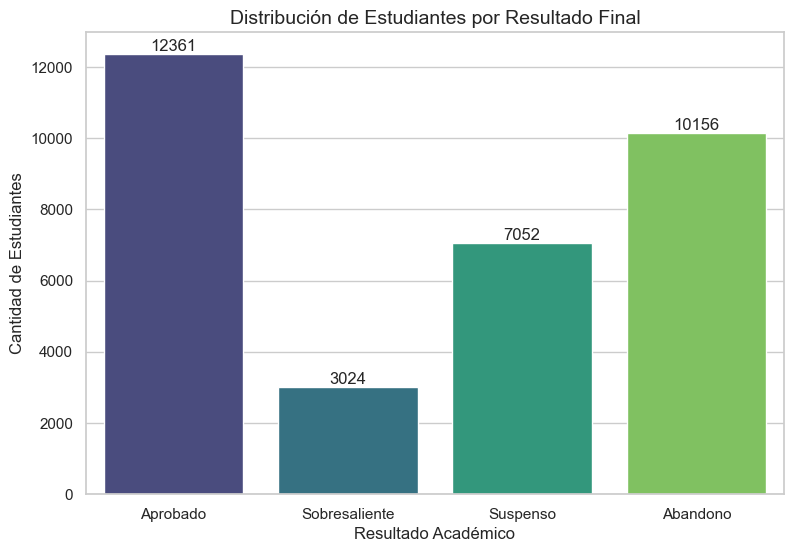

In [4]:
# Traducción de etiquetas para la gráfica
translation_map = {
    'Pass': 'Aprobado',
    'Distinction': 'Sobresaliente',
    'Fail': 'Suspenso',
    'Withdrawn': 'Abandono'
}

df_students['Resultado'] = df_students['final_result'].map(translation_map)

plt.figure(figsize=(9, 6))
ax = sns.countplot(
    data=df_students, 
    x='Resultado', 
    palette='viridis', 
    order=['Aprobado', 'Sobresaliente', 'Suspenso', 'Abandono']
)

# Añadir etiquetas de valor encima de las barras
for i in ax.containers:
    ax.bar_label(i)

plt.title("Distribución de Estudiantes por Resultado Final", fontsize=14)
plt.xlabel("Resultado Académico", fontsize=12)
plt.ylabel("Cantidad de Estudiantes", fontsize=12)
plt.show()

**Observaciones:** El análisis de la distribución de clases revela un escenario complejo que justifica la necesidad de modelos avanzados. Si planteamos el problema de forma binaria como "Persistencia" (Aprobado + Sobresaliente ≈ 15.3k) frente a "Riesgo" (Suspenso + Abandono ≈ 17.2k), el dataset se encuentra razonablemente balanceado, lo cual es ideal para el entrenamiento. Sin embargo, al desglosar el riesgo, observamos que el Abandono (10.1k) es significativamente más frecuente que el Suspenso académico (7k). Esta disparidad refuerza la hipótesis de que la deserción es el problema principal a atajar y sugiere que un modelo multiclasificador será más efectivo para distinguir entre quien se va prematuramente y quien falla por rendimiento.

## 2. Estudio de interacciones de los estudiantes

El dataset OULAD posee una naturaleza intrínsecamente secuencial que lo distingue de los conjuntos de datos estáticos tradicionales. Tanto las interacciones diarias en el VLE (date, sum_click) como las evaluaciones (date_submitted, score) se distribuyen a lo largo del tiempo, conformando la "huella digital" del aprendizaje de cada estudiante semana a semana. Esta estructura temporal es el fundamento ideal para la aplicación de arquitecturas basadas en Transformers. Al igual que estos modelos procesan palabras en una oración para entender el contexto, aquí procesaremos la secuencia de comportamientos semanales del alumno para predecir su trayectoria futura, permitiendo al sistema capturar dependencias a largo plazo (e.g., una baja actividad en la semana 2 que repercute en el examen de la semana 10) que modelos clásicos pasarían por alto.

### 2.1 Clics promedios diarios

Si miramos a un solo estudiante, su gráfica podría ser engañosa: quizás ese alumno solo estudia los domingos, o quizás se puso enfermo una semana. Al usar el promedio de todos, lo que emerge es el ritmo real del curso. Verás que todos los alumnos (en promedio) suben su actividad justo antes de una entrega. El promedio nos permite ver los hitos del calendario académico que afectan a la masa.

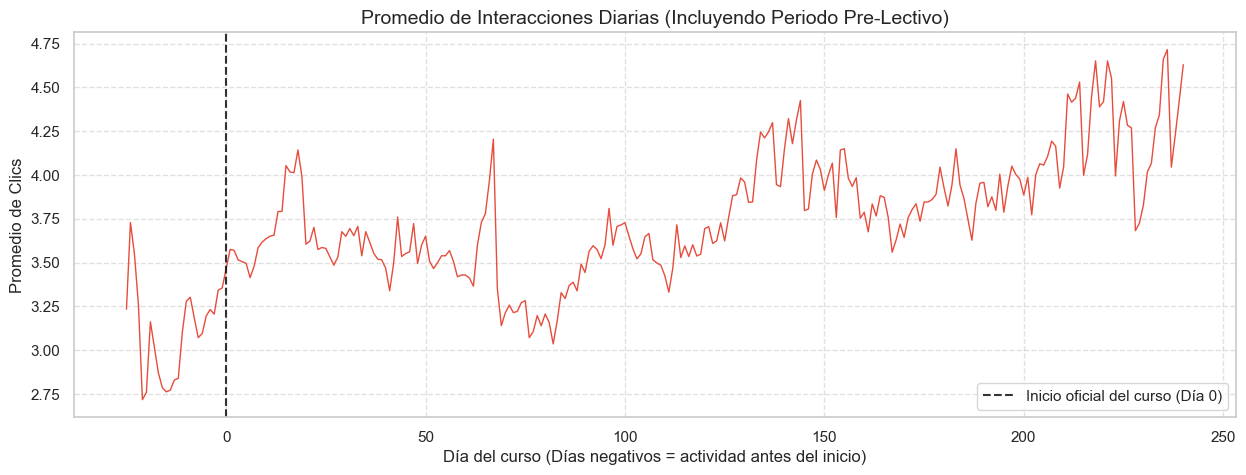

In [7]:
# 1. Calculamos el promedio de clics diarios de todos los estudiantes
daily_activity = df_interactions.groupby('date')['sum_click'].mean().reset_index()

# 2. Modificamos el filtro para incluir la actividad PREVIA (desde el día -25)
# Mantenemos el límite de 240 para no desvirtuar el final
daily_activity_filtered = daily_activity[(daily_activity['date'] >= -25) & (daily_activity['date'] <= 240)]

plt.figure(figsize=(15, 5))

# 3. Dibujamos la línea de actividad
plt.plot(daily_activity_filtered['date'], daily_activity_filtered['sum_click'], color='#e74c3c', linewidth=1)

# 4. Añadimos una línea vertical en el Día 0 para marcar el inicio oficial
plt.axvline(x=0, color='black', linestyle='--', alpha=0.8, label='Inicio oficial del curso (Día 0)')

plt.title('Promedio de Interacciones Diarias (Incluyendo Periodo Pre-Lectivo)', fontsize=14)
plt.xlabel('Día del curso (Días negativos = actividad antes del inicio)', fontsize=12)
plt.ylabel('Promedio de Clics', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

**Observaciones:**  Se aprecia un alto nivel de ruido y volatilidad en la actividad diaria (efecto sierra), lo que dificultaría el entrenamiento de un modelo de IA. También se confirma actividad relevante en los días previos al inicio oficial (Día < 0). Esta inestabilidad justifica la agregación semanal, necesaria para limpiar el ruido y capturar patrones de comportamiento más robustos y útiles para el modelo.

### 2.2 clics promedio semanales

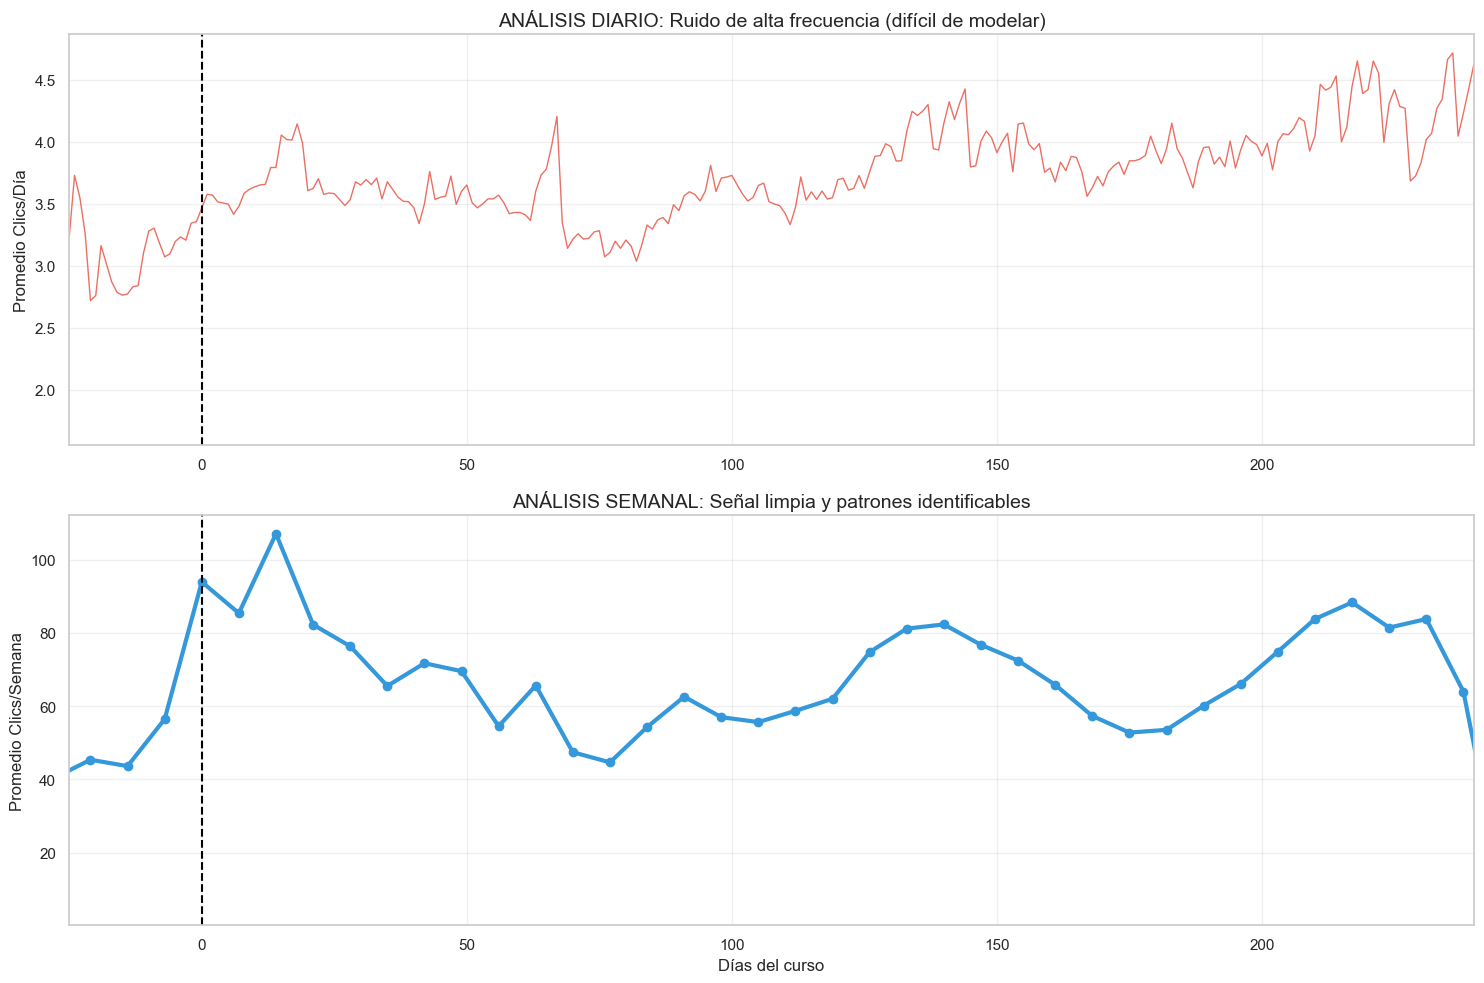

In [9]:
# 1. Preparamos los datos
# Actividad Diaria
daily_avg = df_interactions.groupby('date')['sum_click'].mean().reset_index()

# Actividad Semanal (Agrupamos primero por estudiante/semana y luego promediamos)
df_interactions['week'] = df_interactions['date'] // 7
weekly_avg = df_interactions.groupby(['id_student', 'week'])['sum_click'].sum().reset_index()
weekly_trend = weekly_avg.groupby('week')['sum_click'].mean().reset_index()

# 2. Configuración de la comparativa
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=False)

# Gráfica Superior: Ruido Diario
ax1.plot(daily_avg['date'], daily_avg['sum_click'], color='#e74c3c', linewidth=1, alpha=0.8)
ax1.set_xlim(-25, 240)
ax1.axvline(x=0, color='black', linestyle='--')
ax1.set_title('ANÁLISIS DIARIO: Ruido de alta frecuencia (difícil de modelar)', fontsize=14)
ax1.set_ylabel('Promedio Clics/Día')
ax1.grid(True, alpha=0.3)

# Gráfica Inferior: Señal Semanal
# Multiplicamos X por 7 para mantener la misma escala temporal que los días
ax2.plot(weekly_trend['week'] * 7, weekly_trend['sum_click'], color='#3498db', linewidth=3, marker='o')
ax2.set_xlim(-25, 240)
ax2.axvline(x=0, color='black', linestyle='--')
ax2.set_title('ANÁLISIS SEMANAL: Señal limpia y patrones identificables', fontsize=14)
ax2.set_ylabel('Promedio Clics/Semana')
ax2.set_xlabel('Días del curso')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Observaciones:** El contraste visual es definitivo: mientras que la serie diaria está saturada de variaciones bruscas (ruido) que no aportan valor predictivo, la agregación semanal filtra esas fluctuaciones y revela la estructura real del curso.

Al usar semanas, transformamos datos caóticos en una serie temporal limpia donde destacan los hitos académicos. Esta es la base que permitirá al modelo (Transformer/RNN) aprender de forma eficiente, evitando que se pierda en detalles irrelevantes del día a día y centrando su capacidad en la evolución del compromiso del estudiante.

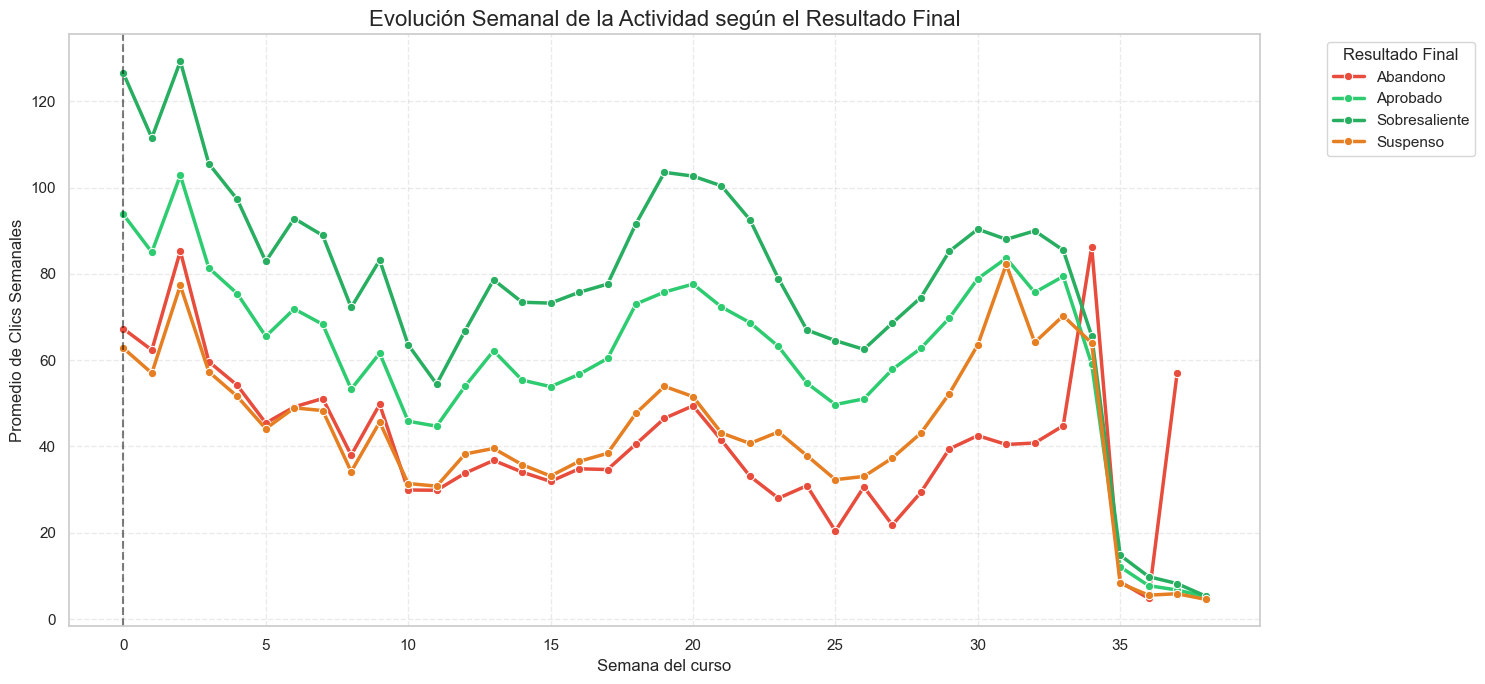

In [10]:
# 1. Agrupamos por resultado y semana, calculando el promedio de clics
# Usamos el dataframe 'weekly_activity' que ya tiene el merge con 'final_result'
result_trends = weekly_activity.groupby(['Resultado', 'week'])['sum_click'].mean().reset_index()
# 2. Visualización
plt.figure(figsize=(15, 7))
# Definimos colores que sigan una lógica (Verdes para éxito, Rojos para fallo)
custom_palette = {
    'Sobresaliente': '#27ae60', # Verde oscuro
    'Aprobado': '#2ecc71',      # Verde claro
    'Suspenso': '#e67e22',      # Naranja
    'Abandono': '#e74c3c'       # Rojo
}
sns.lineplot(
    data=result_trends, 
    x='week', 
    y='sum_click', 
    hue='Resultado', 
    palette=custom_palette,
    linewidth=2.5,
    marker='o'
)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.title('Evolución Semanal de la Actividad según el Resultado Final', fontsize=16)
plt.xlabel('Semana del curso', fontsize=12)
plt.ylabel('Promedio de Clics Semanales', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='Resultado Final', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Observaciones:** Se aprecia una distorsión de los datos en las últimas semanas del grupo de Abandono, con un pico de actividad atípico. Esto se debe a la baja representatividad estadística (pocos alumnos residuales), donde acciones individuales —como entrar a descargar materiales antes de irse o consultar notas finales en el "cierre de actas"— disparan el promedio. Dada esta volatilidad por falta de volumen, es recomendable truncar o normalizar los datos finales antes de alimentar el modelo de IA para evitar sesgos.

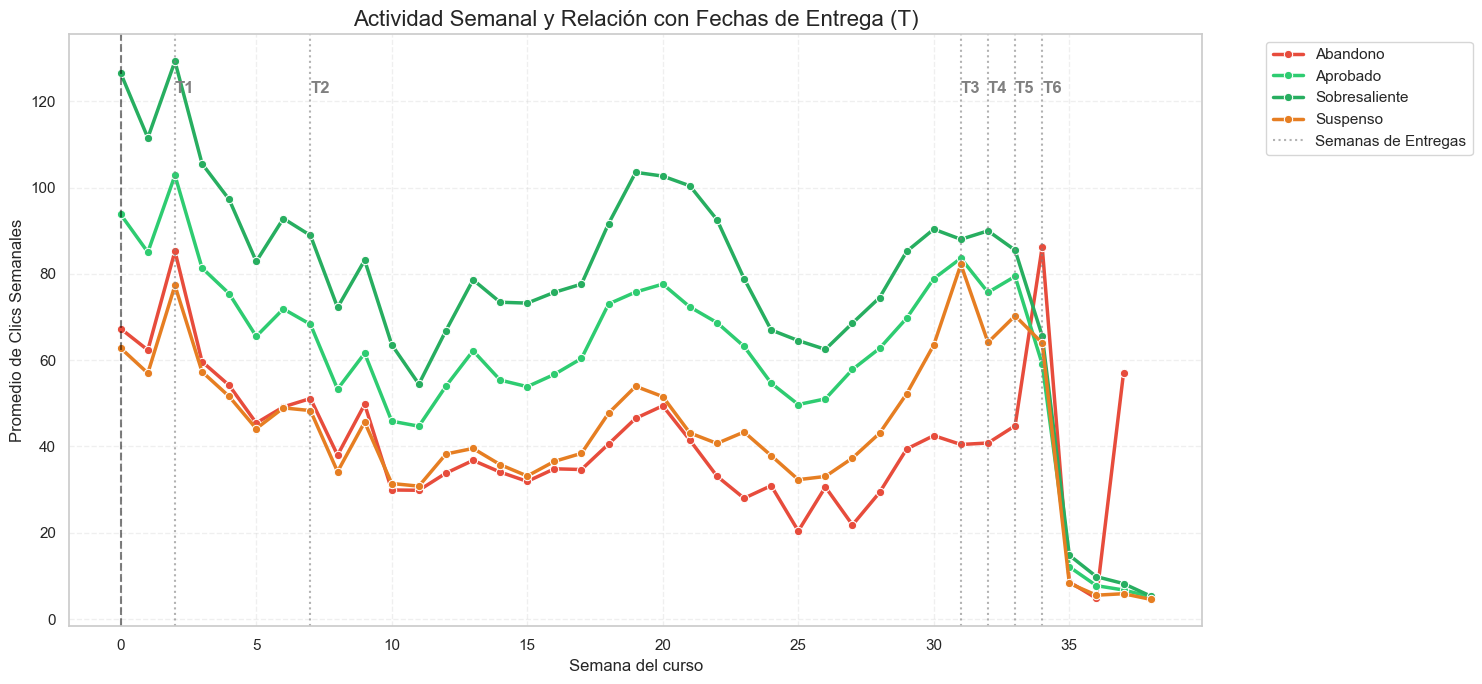

In [13]:
# 1. Identificamos las semanas con más entregas (Deadlines)
# Convertimos los días de 'assessments' a semanas
df_assessments['week_deadline'] = df_assessments['date'] // 7
# Elegimos las semanas donde hay una masa crítica de entregas
top_deadlines = df_assessments['week_deadline'].value_counts().head(6).index.sort_values()
# 2. Generamos la gráfica de nuevo
plt.figure(figsize=(15, 7))
sns.lineplot(
    data=result_trends, 
    x='week', y='sum_click', hue='Resultado', 
    palette=custom_palette, linewidth=2.5, marker='o'
)
# 3. Añadimos las líneas de los trabajos (Deadlines)
for i, deadline_week in enumerate(top_deadlines):
    label = 'Semanas de Entregas' if i == 0 else "" # Para no repetir en la leyenda
    plt.axvline(x=deadline_week, color='gray', linestyle=':', alpha=0.6, label=label)
    plt.text(deadline_week, plt.ylim()[1]*0.9, f'T{i+1}', rotation=0, color='gray', fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.title('Actividad Semanal y Relación con Fechas de Entrega (T)', fontsize=16)
plt.xlabel('Semana del curso', fontsize=12)
plt.ylabel('Promedio de Clics Semanales', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## Hallazgos del Análisis Temporal

*   **Brecha de Actividad**: Se observa una clara separación entre estudiantes excelentes y en riesgo durante el ecuador del curso (Semanas 15-25). Los alumnos de alto rendimiento son proactivos, mientras que los de bajo rendimiento son reactivos a las entregas.
*   **Limitación de Hitos Globales**: Los picos de actividad no siempre coinciden con los *deadlines* globales de la universidad, lo que sugiere que para la IA será vital capturar patrones específicos de cada módulo.
*   **Señal vs Ruido**: La agregación semanal es fundamental para eliminar la volatilidad diaria y permitir que el modelo capture la trayectoria real del estudiante.

## 3. Correlación: Clics Totales vs Nota Media
¿Estudiar más (más clics) garantiza mejor nota?

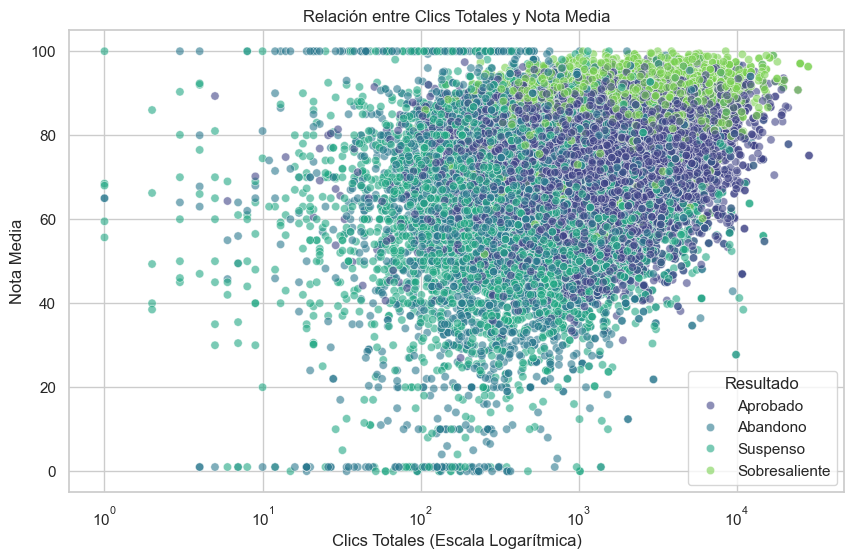

In [12]:
# Calculamos clics totales por estudiante
total_clicks = df_interactions.groupby('id_student')['sum_click'].sum().reset_index()
total_clicks.rename(columns={'sum_click': 'total_clicks'}, inplace=True)

# Calculamos nota media por estudiante (en evaluaciones puntuables)
avg_score = df_assessments.groupby('id_student')['score'].mean().reset_index()
avg_score.rename(columns={'score': 'mean_score'}, inplace=True)

# Unimos
analysis_df = pd.merge(total_clicks, avg_score, on='id_student')
analysis_df = pd.merge(analysis_df, df_students[['id_student', 'final_result']], on='id_student')

# Traducción para visualización
analysis_df['Resultado'] = analysis_df['final_result'].map(translation_map)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=analysis_df, x='total_clicks', y='mean_score', hue='Resultado', alpha=0.6, palette='viridis')
plt.title("Relación entre Clics Totales y Nota Media")
plt.xscale('log') # Escala logarítmica porque suele haber outliers con muchísimos clics
plt.xlabel("Clics Totales (Escala Logarítmica)")
plt.ylabel("Nota Media")
plt.show()